<a href="https://colab.research.google.com/github/asetya/BigData/blob/master/Copy_of_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Praktikum Prediksi Time Series** 

Arief Setyanto 

Data runtun waktu merupakan data yang berurutan, dimana urutan berpengaruh artinya jika urutannya di balik data akan memiliki makna yang berbeda. 
Data sequensial ada cukup banyak misalnya data harga saham harian, data suara, data text yang misalkan berbunyi "saya makan tahu", jika di balik "tahu makan saya" maka maknanya akan berubah. 

Dalam tulisan ini di buat sebuah contoh data runtun waktu dari tahun 15 Juli 2010 sampai 15 Juli 2020 - saat tutorial ini dibuat dari data fluktuasi harga saham yang dapat di download di sini : https://ca.finance.yahoo.com/quote/%5Evix/history?ltr=1

Tentunya jika anda memiliki data lain dengan mudah bisa disesuaikan. 
Materi ini di adaptasi dari : https://mc.ai/an-introduction-on-time-series-forecasting-with-simple-neura-networks-lstm/
dengan beberapa catatan penyesuaian : 
1. untuk spliting data saya tidak menggunakan library Timestamp dari  Library Panda
2. Untuk data training dan data testing tidak dilakukan pengacakan random karena sifat data time series yang tergantung urutan waktu maka pengacakan menjadi tidak masuk akal - (silakan lihat tutorial aslinya) jika dipakai pengacakan hasil forecasting akan menjadi buruk



Import Library 

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Siapkan tempat untuk menyimpan file di google colab- jika anda menggunakan tutorial ini d komputer lokal, langkah ini tidak perlu 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Mengcopy file data dari lokal ke google colab 

In [ ]:
!cp /content/drive/My\ Drive/20102020VIX.csv /content/


Mambaca file csv (jika anda memiliki file dengan format lain dapat disesuaikan) 

In [ ]:
df = pd.read_csv("20102020VIX.csv")

Menampilkan data data pada dataframe (df) kita

In [ ]:
df.head()

,Adj Close
Date,
2010-07-15,25.139999
2010-07-16,26.250000
2010-07-19,25.969999
2010-07-20,23.930000
2010-07-21,25.639999


Membuang kolom yang tidak diperlukan 

In [ ]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
ind_df = df.set_index(['Date'], drop=True)
ind_df


,Adj Close
Date,
2010-07-15,25.139999
2010-07-16,26.250000
2010-07-19,25.969999
2010-07-20,23.930000
2010-07-21,25.639999
...,...
2020-07-08,28.080000
2020-07-09,29.260000
2020-07-10,27.290001


Mengurutkan data berdasarkan indexnya - pada bagian program sebelumnya di tentukan indeksnya adalah date

Memplot kolom 'Adj Close' secara berurutan berdasarkan waktu

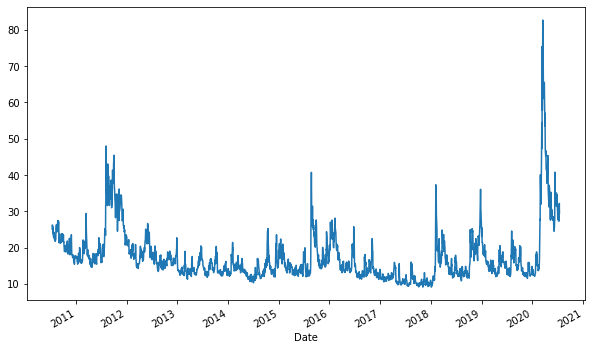

In [ ]:
nd_df = ind_df.sort_index()
plt.figure(figsize=(10, 6))
ind_df['Adj Close'].plot();

Memisahkan dataset menjadai data latih (train) dan data uji (test) 

Dalam contoh ini batas tanggalnya adalah 2017-07-21 - tanggal ini bisa anda tentukan sendiri 

dilanjutkan dengan memplot pada grafik runtun waktu - yang berwarnba biru adalah data latih sedangkan orange adalah data test. 


<Figure size 720x432 with 0 Axes>

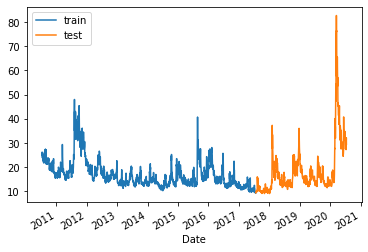

In [ ]:
#split_date = pd.Timestamp('2018-01-01')
#df  = df['Adj Close']
df = df.set_index(['Date'], drop=True)
train = df.loc[:'2017-07-21']
test = df.loc['2017-07-22':]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

menampilkan ukuran (shape dari data train) 

In [ ]:
train.shape

(1768, 1)

Menampilkan ukuran (shape) dari data uji 

In [ ]:
test.shape

Mengatur skala menggunakan scaler menjadi antara -1 sampai dengan 1 untuk data training maupun data testing 


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

menampilkan shape dari data training setelah di atur ulang skalanya

In [ ]:
train_sc.shape


(1768, 1)

In [ ]:
test_sc.shape

(749, 1)

In [ ]:
#np.random.shuffle(train_sc)

Mengatur X_train dan y_train untuk melatih sistem menggunakan Neural Network 

In [ ]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

In [ ]:
X_train[0:5]

array([[-0.51086962],
       [-0.60455487],
       [-0.36387164],
       [-0.79037267],
       [-0.73395445]])

In [ ]:
y_train[0:5]

array([[-0.60455487],
       [-0.36387164],
       [-0.79037267],
       [-0.73395445],
       [-0.59161491]])

Membuat Arsitektur Neural Network dan memberikan pelatihan untuk mencari parameter terbaiknya dengan epoch (iterasi maksimum) sebanyak 100 


In [ ]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1767/1767 [==============================] - 1s 818us/step - loss: 0.0104
Epoch 2/100
1767/1767 [==============================] - 1s 812us/step - loss: 0.0066
Epoch 3/100
1767/1767 [==============================] - 1s 810us/step - loss: 0.0063
Epoch 4/100
1767/1767 [==============================] - 1s 806us/step - loss: 0.0063
Epoch 5/100
1767/1767 [==============================] - 1s 799us/step - loss: 0.0062
Epoch 6/100
1767/1767 [==============================] - 1s 822us/step - loss: 0.0062
Epoch 7/100
1767/1767 [==============================] - 1s 816us/step - loss: 0.0062
Epoch 8/100
1767/1767 [==============================] - 1s 811us/step - loss: 0.0062
Epoch 9/100
1767/1767 [==============================] - 1s 818us/step - loss: 0.0061
Epoch 10/100
1767/1767 [==============================] - 1s 822us/step - loss: 0.0061
Epoch 11/100
1767/1767 [==============================] - 1s 817us/step - loss: 0.0061
Epoch 12/100
1767/1767 [============================

Membuat X_test dan Y_test dari data uji yang sudah diatur skalanya

In [ ]:
X_test = test_sc[:-1]
y_test = test_sc[1:]

Menggunakan model untuk memprediksi y_train dan y_test lalu menampillan skornya

In [ ]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.907
The R2 score on the Test set is:	0.860


Mengubah matrix masukan X_train untuk dimensinya disesuaikan dengan masukan yang diminta oleh LSTM 

In [ ]:


X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (1767, 1, 1)
Test shape:  (748, 1, 1)


Membuat arsitektur LSTM dan melatih LTSM menggunakan x_train_lmse - yang sudah disesuaikan dimensinya 

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
print(lstm_model)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1767/1767 [==============================] - 3s 2ms/step - loss: 0.0203
Epoch 2/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0079
Epoch 3/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0063
Epoch 4/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 5/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 6/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 7/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 8/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 9/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 10/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 11/100
1767/1767 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 12/100
1767/1767 [==============================] - 2s 1ms/step - lo

Menggunakan model yang diperoleh untuk memprediksi y_yest dan y_train serta menampilkan hasilnya 

In [ ]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.906
The R2 score on the Test set is:	0.907


Membandingkan kedua alghortima (NN dan LSTM) dengan mengecek MSE (mean square error) yang diperoleh 

In [ ]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

748/748 [==============================] - 0s 576us/step
NN: 0.039347
LSTM: 0.026051


Menggunakan model dan di test menggunakan data testing menggunakan model NN dan LSTM yang sudah dilatih pada tahap sebelumnya

In [ ]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

Menampilkan (plot) hasil forecasting dan data asli untyuk forecasting dengan NN 

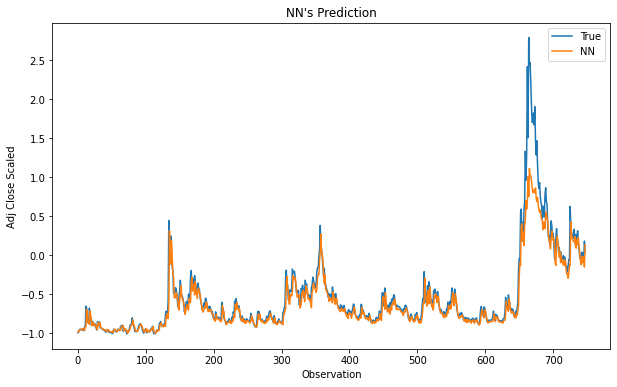

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("NN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

Menampilkan (plot) hasil forecasting dan data asli untyuk forecasting dengan LSTM

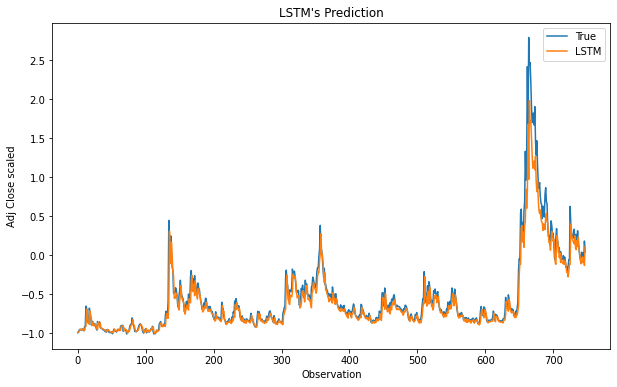

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show()